# Imports

In [1]:
orthologous_genes_folder = '/home/olga/googledrive/TabulaMicrocebus/data/orthologous-genes'
# ! ls -lha $orthologous_genes_folder

In [2]:
import os

import anndata
import scanpy as sc
import pandas as pd
import seaborn as sns


sc.settings.verbosity = 3
sc.logging.print_versions()

pd.options.display.max_rows = 200


outdir_gdrive = "/home/olga/googledrive/TabulaMicrocebus/data/cross-species"
outdir_local = "/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species"
outdirs = outdir_gdrive, outdir_local

-----
anndata     0.7.5
scanpy      1.7.0rc1
sinfo       0.3.1
-----
anndata             0.7.5
backcall            0.1.0
cairo               1.18.2
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.0
decorator           4.4.1
get_version         2.1
h5py                2.10.0
igraph              0.7.1
importlib_metadata  0.19
ipykernel           5.1.3
ipython_genutils    0.2.0
jedi                0.15.1
joblib              0.14.1
kiwisolver          1.1.0
legacy_api_wrap     0.0.0
leidenalg           0.7.0
llvmlite            0.30.0
louvain             0.6.1
matplotlib          3.1.2
more_itertools      NA
mpl_toolkits        NA
natsort             6.2.0
numba               0.46.0
numexpr             2.7.0
numpy               1.17.3
packaging           20.8
pandas              1.1.4
parso               0.5.1
pexpect             4.7.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.2
ptyprocess          0.6.0
pyg

## Load mega-object

In [3]:
%%time

h5ad = os.path.join(
    outdir_local, "concatenated__human-lemur-mouse_10x__one2one_orthologs.h5ad"
)
combined = sc.read(h5ad)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


CPU times: user 2.67 s, sys: 5.08 s, total: 7.75 s
Wall time: 10.2 s


In [4]:
!ls  -lha $h5ad

-rw-r--r-- 1 olga czb 7.9G Feb 15 11:43 /home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated__human-lemur-mouse_10x__one2one_orthologs.h5ad


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


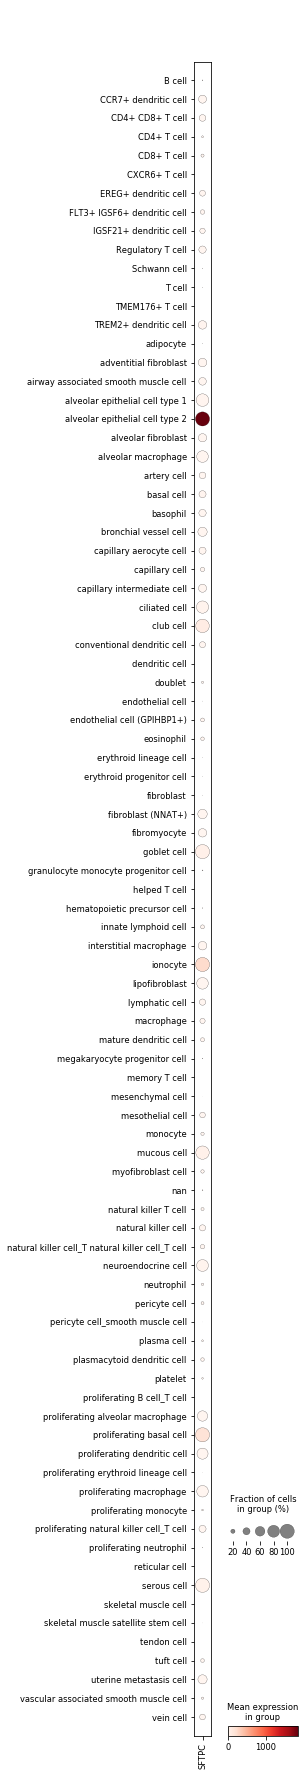

In [5]:
sc.pl.dotplot(combined, var_names=['SFTPC'], groupby='narrow_group')

In [6]:
combined.obs.tissue.value_counts()

Lung                      145335
Blood                      80469
Spleen                     51584
Marrow                     39125
Kidney                     37949
Bone_marrow                34521
Bladder                    34232
Skin                       28964
Limb_Muscle                28176
Tongue                     26363
Thymus                     21150
Fat                        19852
Pancreas                   18727
Liver                      15355
Bone                       14851
Trachea                    14639
Muscle                     12974
Mammary_Gland              11954
Lymph_Node                  8640
Heart_and_Aorta             8253
Vasculature                 8005
Small_intestine             5878
Testes                      5817
Mammary_gland               5468
Brain                       5463
Heart                       4287
Large_Intestine             3251
Limb_muscle                 3125
Bone_Marrow                 2845
Hypothalamus_Pituitary      2526
Uterus    

In [7]:
combined.obs.groupby(['species_batch', 'tissue']).size()

species_batch             tissue                
mouse_tabula_muris_senis  Aorta                         0
                          Bladder                    8752
                          Blood                         0
                          Bone                          0
                          Bone_Marrow                   0
                          Bone_marrow                   0
                          Brain                         0
                          Colon                         0
                          Diaphragm                     0
                          Eye_retina                    0
                          Fat                        6534
                          Heart                         0
                          Heart_and_Aorta            8253
                          Hypothalamus_Pituitary        0
                          Kidney                    21038
                          Large_Intestine            1845
                       

# Subset to Lung, Blood, Muscle and write to file

In [8]:
tissues = "Lung", "Blood", "Muscle", "Bladder"
tissues = {
    "lung": ("Lung",),
    "blood": ("Blood",),
    "muscle": ("Muscle", "Limb_Muscle", "Limb_muscle"),
    "bladder": ("Bladder",),
}


tissue_to_celltype_col = {
    'lung': 'narrow_group',
    'blood': 'narrow_group',
    'muscle': 'narrow_group',
    'bladder': 'cell_ontology_class'
}

In [9]:
def remove_unused_obs_categories(adata):
    """Remove all unused cell ontology class, free annotations, ages, etc using pandas"""
    for col_name, col_series in adata.obs.items():
        try:
            adata.obs[col_name] = col_series.cat.remove_unused_categories()
        except AttributeError:
            continue
    return adata




for tissue_key, tissue_names in tissues.items():
    print(f'--- {tissue_key} ---')
    combined_tissue = combined[combined.obs.tissue.isin(tissue_names)]
    
    # Remove all unused cell ontology class, free annotations, ages, etc
    combined_tissue = remove_unused_obs_categories(combined_tissue)
    
    celltype_col = tissue_to_celltype_col[tissue_key]
    print(combined_tissue.obs.groupby([celltype_col, 'species_batch']).size())
    
    print(combined_tissue)
#     for d in outdirs:
    h5ad = os.path.join(
        outdir_local,
        f'concatenated__human-lemur-mouse_10x__one2one_orthologs__{tissue_key}.h5ad')

    print(h5ad)
    %time combined_tissue.write(h5ad)

--- lung ---


Trying to set attribute `.obs` of view, copying.


narrow_group                            species_batch           
B cell                                  mouse_tabula_muris_senis    1457
                                        human_hlca                   237
                                        human_sapiens                286
                                        lemur                        241
CCR7+ dendritic cell                    mouse_tabula_muris_senis      15
                                                                    ... 
vascular associated smooth muscle cell  lemur                         20
vein cell                               mouse_tabula_muris_senis     306
                                        human_hlca                  1100
                                        human_sapiens                  0
                                        lemur                        122
Length: 300, dtype: int64
AnnData object with n_obs × n_vars = 145335 × 13302
    obs: 'age', 'cell_id', 'cell_ontology_class', 'cel

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.48 s, sys: 1.22 s, total: 2.7 s
Wall time: 4.24 s
--- blood ---
narrow_group                              species_batch
B cell                                    mouse_ce          1876
                                          human_hlca         237
                                          human_sapiens      883
                                          lemur              731
CD4+ T cell                               mouse_ce           578
                                          human_hlca        2543
                                          human_sapiens        0
                                          lemur             1834
CD8+ T cell                               mouse_ce           477
                                          human_hlca        2068
                                          human_sapiens        0
                                          lemur              156
CXCR6+ T cell                             mouse_ce            19
                 

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.31 s, sys: 574 ms, total: 1.88 s
Wall time: 2.57 s
--- muscle ---
narrow_group                              species_batch           
B cell                                    mouse_tabula_muris_senis     1472
                                          human_sapiens                   5
                                          lemur                         213
CD4+ T cell                               mouse_tabula_muris_senis        0
                                          human_sapiens                   0
                                          lemur                         628
CD8+ T cell                               mouse_tabula_muris_senis        0
                                          human_sapiens                   0
                                          lemur                          37
Schwann cell                              mouse_tabula_muris_senis      270
                                          human_sapiens                   0
             

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.09 s, sys: 389 ms, total: 1.48 s
Wall time: 1.93 s
--- bladder ---
cell_ontology_class                     species_batch           
B cell                                  mouse_tabula_muris_senis       0
                                        human_sapiens                216
                                        lemur                         37
CD4-positive, alpha-beta T cell         mouse_tabula_muris_senis       0
                                        human_sapiens                  0
                                        lemur                        374
CD8-positive, alpha-beta T cell         mouse_tabula_muris_senis       0
                                        human_sapiens               2087
                                        lemur                          0
NK cell                                 mouse_tabula_muris_senis       0
                                        human_sapiens                172
                                        lemur  

In [10]:
combined_tissue.obs.groupby(['narrow_group', 'species_batch']).size()

narrow_group                                      species_batch           
B cell                                            mouse_tabula_muris_senis       0
                                                  human_sapiens                216
                                                  lemur                         37
CD4+ T cell                                       mouse_tabula_muris_senis       0
                                                  human_sapiens                  0
                                                  lemur                        374
FLT3+ IGSF6+ dendritic cell                       mouse_tabula_muris_senis       0
                                                  human_sapiens                  0
                                                  lemur                         11
Schwann cell                                      mouse_tabula_muris_senis       0
                                                  human_sapiens                  0
            

In [11]:
combined_tissue

AnnData object with n_obs × n_vars = 34232 × 13302
    obs: 'age', 'cell_id', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'n_genes', 'sex', 'subtissue', 'tissue', 'species', 'species_latin', 'channel', 'sequencing_run', 'cell_barcode', 'n_counts', 'individual', 'narrow_group', 'broad_group', 'compartment_group', 'cell_id_v1', 'cell_id_v2', 'species_batch'
    var: 'mouse_lemur__gene_name-human_hlca', 'mouse__gene_name-human_hlca', 'ensembl_id-human_sapiens', 'len-human_sapiens', 'mouse_lemur__gene_name-lemur', 'mouse__gene_name-lemur', 'name-lemur', 'highly_variable-lemur', 'mouse_lemur__gene_name-mouse_ce', 'mouse__gene_name-mouse_ce', 'n_cells-mouse_tabula_muris_senis', 'mouse_lemur__gene_name-mouse_tabula_muris_senis', 'mouse__gene_name-mouse_tabula_muris_senis'

In [12]:
combined_tissue.obs.dtypes

age                    category
cell_id                category
cell_ontology_class    category
cell_ontology_id       category
free_annotation        category
n_genes                 float64
sex                    category
subtissue              category
tissue                 category
species                category
species_latin          category
channel                category
sequencing_run         category
cell_barcode           category
n_counts                float64
individual             category
narrow_group           category
broad_group            category
compartment_group      category
cell_id_v1             category
cell_id_v2             category
species_batch          category
dtype: object

In [13]:
for col_name, col_series in combined_tissue.obs.items():
    try:
        combined_tissue.obs[col_name] = col_series.cat.remove_unused_categories()
    except AttributeError:
        continue

In [14]:
h5ad

'/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated__human-lemur-mouse_10x__one2one_orthologs__bladder.h5ad'

In [15]:
outdirs

('/home/olga/googledrive/TabulaMicrocebus/data/cross-species',
 '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species')

In [16]:
! ls -lha $h5ad

-rw-r--r-- 1 olga czb 495M Feb 15 11:53 /home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated__human-lemur-mouse_10x__one2one_orthologs__bladder.h5ad
